# Goal

Goal (a): to calculate the Mean Squared Error of multiple cryptocurrencies, namely BTC, ETH and NEO, and plot the MSE.

Goal (b): to plot MSE vs number of days of prediction, to have an idea of how far in the future the current prediction algorithm [Prophet](https://github.com/facebook/prophet)

## Import data

In [2]:
import requests
import pandas as pd
import datetime
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [3]:
    def get_daily_price(coin):
        """"""
        url = 'http://coincap.io/history/{}'.format(coin)
        response_json = requests.get(url).json()
        print("Days retrieved: {}".format(len(response_json['price'])))
        list_prices = []
        for price in response_json['price']:
            datetime_info = datetime.datetime.fromtimestamp(price[0]/1000)

            # neglect hourly info
            date1 = datetime_info.date()

            list_prices.append({'timestamp': date1,
                                'close': price[1]})
        return pd.DataFrame(list_prices)

In [4]:
eth = get_daily_price('ETH')
neo = get_daily_price('NEO')
btc = get_daily_price('BTC')

Days retrieved: 919
Days retrieved: 522
Days retrieved: 1736


In [6]:
eth.tail()

close   timestamp
914  797.954  2018-02-09
915  897.326  2018-02-10
916  829.292  2018-02-11
917  830.674  2018-02-11
918  871.411  2018-02-12

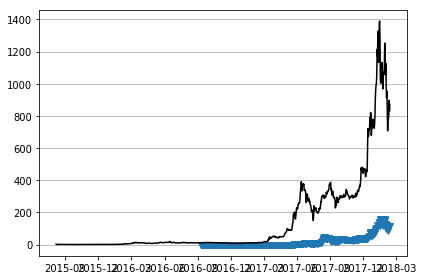

In [7]:
# Plot different cryptocurrencies
import matplotlib.dates as md
fig, ax = plt.subplots()
#neo.plot(x='timestamp', y='close', style='o')
####

ax.plot_date(neo.timestamp, neo.close, 'v-')
ax.plot_date(eth.timestamp, eth.close, 'k-')
#ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),
#                                                interval=7))

#ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
#ax.xaxis.set_major_locator(dates.MonthLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
plt.tight_layout()
plt.show()


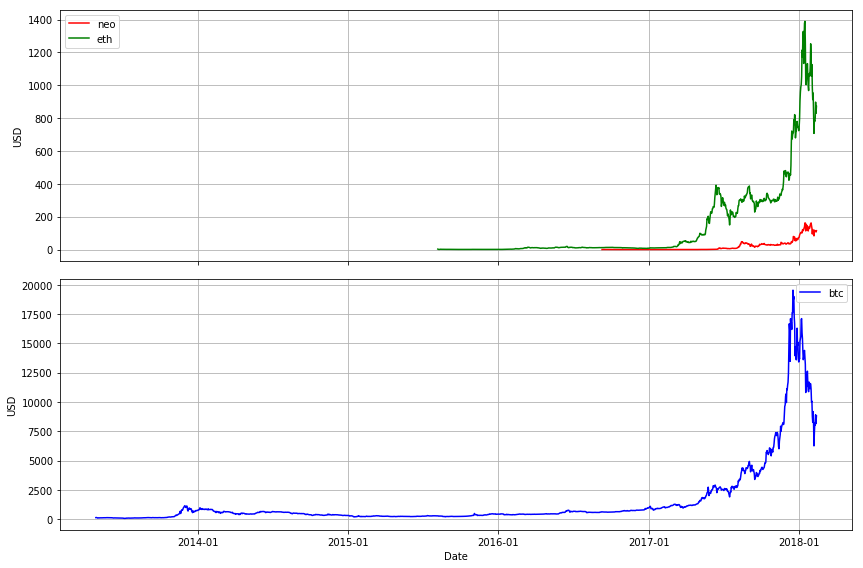

In [8]:
import matplotlib.dates as mdates
fig, axes = plt.subplots(ncols=1,nrows=2, figsize=(8, 8), sharex='col')
ax = axes[0]
fig.set_figwidth(12)
ax.plot(neo.timestamp, neo.close,'r',label='neo')
ax.plot(eth.timestamp, eth.close,'g',label='eth')
legend = plt.legend()

plt.xlabel('Date')
ax.grid()
ax.set_ylabel('USD')
ax.legend()

##
ax1 = axes[1]
ax1.plot(btc.timestamp, btc.close,'b',label='btc')
plt.tight_layout()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.set_ylabel('USD')
ax1.grid()
ax1.legend()
plt.show()

In [9]:
# Pre-process for prophet
def pre_process_for_prophet(df):
    df['ds'] = df['timestamp']
    df['y'] = df['close']
    forecast_data = df[['ds', 'y']].copy()
    
    return forecast_data

In [10]:
eth = pre_process_for_prophet(eth)
neo = pre_process_for_prophet(neo)
btc = pre_process_for_prophet(btc)

In [11]:
def remove_last_n_days(n_days, df):
    df = df[df.ds <= (datetime.datetime.now() - datetime.timedelta(days=n_days)).date()]
    df = df.groupby('ds', as_index=False).mean()
    return df

In [12]:
def get_last_n_days(n_days, df):
    df = df[df.ds > (datetime.datetime.now() - datetime.timedelta(days=n_days)).date()]    
    df = df.groupby('ds', as_index=False).mean()
    return df

In [25]:
def return_forecast_and_actual(n_days, df):
    # Starting with eth - 1 day prediction
    
    df_minus_n_days = remove_last_n_days(n_days, df)
    df_last_n_days = get_last_n_days(n_days, df)

    m = Prophet(interval_width=0.9, daily_seasonality=True)
    m.fit(df_minus_n_days)
    future = m.make_future_dataframe(periods=n_days, freq='D')
    forecast = m.predict(future)
    
    return [eth_1day_test, forecast]

In [39]:
# Starting with eth - 1 day prediction
from fbprophet import Prophet

n_days=30
eth_1day = remove_last_n_days(n_days, neo)
eth_1day_test = get_last_n_days(n_days, neo)

m = Prophet(interval_width=0.9, daily_seasonality=True)
m.fit(eth_1day)
future_eth = m.make_future_dataframe(periods=n_days, freq='D')
forecast_eth = m.predict(future_eth)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/gabrielfior/miniconda3/envs/pytorch36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [40]:
def compare_predicted_with_real(df_predicted, df_test):
    
    # TODO - modularize
    if isinstance(df_predicted.iloc[-1].ds, pd.Timestamp):
        # convert to date
        df_predicted['ds_date'] = df_predicted['ds'].apply(lambda x: x.date())
    else:
        df_predicted['ds_date'] = df_predicted['ds']
    if isinstance(df_test.iloc[-1].ds, pd.Timestamp):
        df_test['ds_date'] = df_test['ds'].apply(lambda x: x.date())
    else:
        df_test['ds_date'] = df_test['ds']
            
    # merge
    merged = pd.merge(left=df_test, 
                      right=df_predicted, 
                      on='ds_date',
                      suffixes=('_predicted','_test'))
    # calculate diff
    merged['error'] = merged.y - merged.yhat
    merged["uncertainty"] = merged.yhat_upper - merged.yhat_lower
    
    #print(merged.head())
    
    return mean_squared_error(merged['y'], merged['yhat'])

In [42]:
error_list = []
for day_count in range(n_days):
    df_last_n_days, forecast = return_forecast_and_actual(day_count,neo)
    error = compare_predicted_with_real(forecast,df_last_n_days)
    print(error)
    error_list.append([error, day_count])

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/gabrielfior/miniconda3/envs/pytorch36/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


929.5990022598281


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


895.3850219905472


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


897.7792457219275


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


919.9114027168335


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


917.2968682242495


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


916.7199787093692


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


913.2810711050045


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


861.9966882934536


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


843.0855171628156


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


844.6747261484957


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


859.6260615874094


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


855.4411032970958


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


842.3344245213709


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


910.1787708822551


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


959.9967085638706


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


964.422605867355


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1014.4916889751395


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1141.9163595271978


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1090.4912852957466


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1158.3902072985695


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1298.168304648584


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1276.0585139313769


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1375.1354721791934


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1452.3245992381044


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1460.1264305860598


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1749.6655714751703


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1875.6593878460708


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2009.2532700633392


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2303.9498294953987
2596.2259270861177


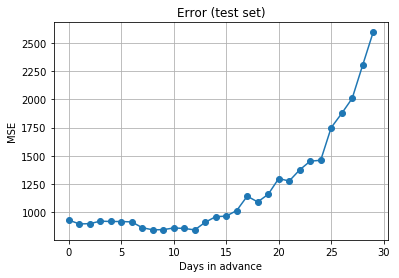

In [43]:
plt.figure(1)
plt.plot(np.array(error_list)[:,1],np.array(error_list)[:,0],'o-')
plt.title('Error (test set)')
plt.xlabel('Days in advance')
plt.ylabel('MSE')
plt.grid()
plt.show()

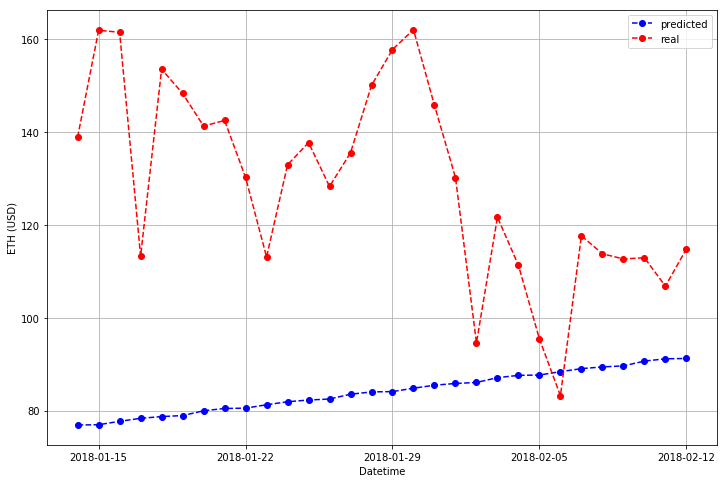

In [45]:
plt.figure(1,figsize=(12,8))
ndays = 30
last_n_days = forecast[forecast.ds>=datetime.datetime.now() - datetime.timedelta(days=ndays)].copy()
plt.plot(last_n_days['ds'], last_n_days['yhat'],'--bo',label='predicted')
plt.plot(df_last_n_days['ds'],df_last_n_days['y'],'--ro',label='real')
plt.legend()
plt.ylabel('ETH (USD)')
plt.xlabel('Datetime')
plt.grid()
plt.show()

In [ ]:
df_last_n_days.tail()